__Example: Modeling__

To fit a lens model to a dataset, we must perform lens modeling, which uses a `NonLinearSearch` to fit many
different tracers to the dataset.

In this example script, we fit `Imaging` of a strong lens system where:

 - The lens galaxy's light is omitted (and is not present in the simulated data).
 - The lens galaxy's total mass distribution is modeled as an `EllipticalIsothermal`.
 - The source galaxy's light is modeled parametrically as an `EllipticalSersic`.

Load the strong lens dataset `mass_sie__source_sersic` `from .fits files, which is the dataset we will
use to perform lens modeling.

This is the same dataset we fitted in the `autolens/intro/fitting.py` example.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.2,
)

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


The model-fit also requires a mask defining the regions of the image we fit the lens model to the data.

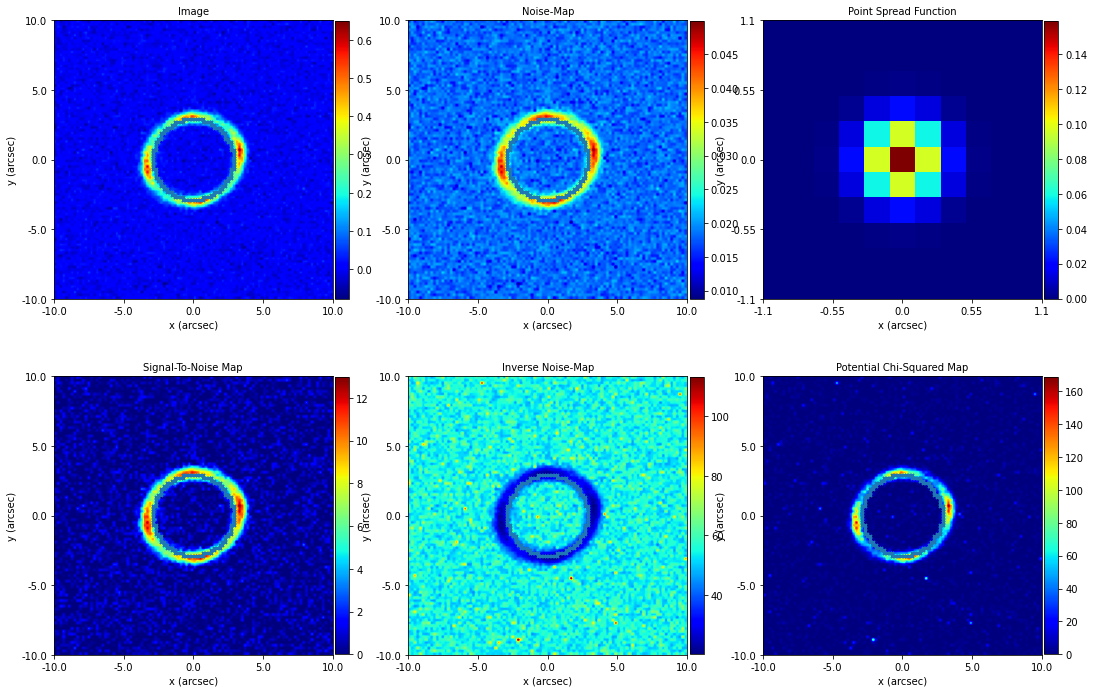

In [2]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Phase__

To perform lens modeling, we create a `PhaseImaging` object, which comprises:

   - The `GalaxyModel`'s used to fit the data.
   - The `SettingsPhase` which customize how the model is fitted to the data.
   - The `NonLinearSearch` used to sample parameter space.

Once we have create the phase, we `run` it by passing it the data and mask.

__Model__

We compose our lens model using `GalaxyModel` objects, which represent the galaxies we fit to our data. In this 
example our lens mooel is:

 - An `EllipticalIsothermal` `MassProfile`.for the lens galaxy's mass (5 parameters).
 - An `EllipticalSersic` `LightProfile`.for the source galaxy's light (7 parameters).

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=12.

NOTE: By default, **PyAutoLens** assumes the image has been reduced such that the lens galaxy centre is at (0.0", 0.0"),
with the priors on the lens `MassProfile` coordinates set accordingly. if for your dataset the lens is not centred at 
(0.0", 0.0"), we recommend you reduce your data so it is (see `autolens_workspace/notebooks/preprocess`).  Alternatively, you 
can manually override the priors (see `autolens_workspace/notebooks/modeling/customize/priors.py`).

In [3]:
lens = al.GalaxyModel(redshift=0.5, mass=al.mp.EllipticalIsothermal)
source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic)

__Settings__

Next, we specify the `SettingsPhaseImaging`, which describe how the model is fitted to the data in the log likelihood
function. Below, we specify:

 - That a regular `Grid2D` is used to fit create the model-image when fitting the data 
      (see `autolens_workspace/examples/grids.py` for a description of grids).
 - The sub-grid size of this grid.

Different `SettingsPhase` are used in different example model scripts and a full description of all `SettingsPhase` 
can be found in the example script `autolens/workspace/notebooks/modeling/customize/settings.py` and the following 
chain -> <chain>

In [4]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

__Search__

The lens model is fitted to the data using a `NonLinearSearch`, which we specify below. In this example, we use the
nested sampling algorithm Dynesty (https://dynesty.readthedocs.io/en/latest/), with:

 - 50 live points.

The script `autolens_workspace/notebooks/modeling/customize/non_linear_searches.py` gives a description of the types of
non-linear searches that can be used with **PyAutoLens**. If you do not know what a `NonLinearSearch` is or how it 
operates, I recommend you complete chapters 1 and 2 of the HowToLens lecture series.

The `name` and `path_prefix` below specify the path where results ae stored in the output folder:  

 `/autolens_workspace/output/sensitivity/mass_sie__source_sersic/phase_mass[sie]_source[bulge]`.

In [5]:
search = af.DynestyStatic(
    path_prefix=path.join("beginner", dataset_name),
    name="phase_mass[sie]_source[bulge]",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

In [6]:
phase = al.PhaseImaging(
    search=search,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
    settings=settings,
)

We can now begin the fit by passing the dataset and mask to the phase, which will use the `NonLinearSearch` to fit
the model to the data. 

The fit outputs visualization on-the-fly, so checkout the path 
`autolens_workspace/output/examples/phase_mass[sie]_source[bulge]` to see how your fit is doing!

In [7]:
result = phase.run(dataset=imaging, mask=mask)

INFO:root:phase_mass[sie]_source[bulge] already completed, skipping non-linear search.


Checkout `autolens_workspace/notebooks/modeling/results.py` for a full description of the result object.

In [8]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

### model ###

galaxies = af.CollectionPriorModel(
    lens=al.GalaxyModel(redshift=0.5, mass=al.mp.EllipticalIsothermal),
    source=al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic),
)

model = af.Model(galaxies)

### perturbation model ###

subhalo = al.GalaxyModel(redshift=0.5, mass=al.mp.SphericalNFWMCRLudlow)
subhalo.mass.mass_at_200 = af.LogUniformPrior(lower_limit=1.0e6, upper_limit=1.0e11)
subhalo.mass.centre_0 = af.UniformPrior(lower_limit=-2.0, upper_limit=2.0)
subhalo.mass.centre_1 = af.UniformPrior(lower_limit=-2.0, upper_limit=2.0)

subhalo.mass.redshift_object = 0.5
subhalo.mass.redshift_source = 1.0

### simulate function ###


def simulate_function(instance):

    tracer = al.Tracer.from_galaxies(
        galaxies=[
            instance.galaxies.lens,
            instance.perturbation,
            instance.galaxies.source,
        ]
    )

    grid = al.Grid2DIterate.uniform(
        shape_native=(100, 100),
        pixel_scales=0.2,
        fractional_accuracy=0.9999,
        sub_steps=[2, 4, 8, 16, 24],
    )

    psf = al.Kernel2D.from_gaussian(
        shape_native=(3, 3), sigma=0.1, pixel_scales=grid.pixel_scales
    )

    simulator = al.SimulatorImaging(
        exposure_time=300.0, psf=psf, background_sky_level=0.1, add_poisson_noise=True
    )

    # tracer = al.Tracer.from_galaxies(galaxies=instance.model)

    imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

    mask = al.Mask2D.circular(
        shape_native=(100, 100), pixel_scales=0.2, sub_size=1, radius=3.0
    )

    return al.MaskedImaging(imaging=imaging, mask=mask)


### Analysis ###

dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.2,
)


from astropy import cosmology as cosmo
from autolens.pipeline.phase.imaging import analysis as a

# TODO : The analysius class can have inputs other than the dataset. Is there a better way to feed this info through to
# TODO : the sensitivty?


class Analysis(a.Analysis):
    def __init__(self, masked_imaging):

        super().__init__(
            masked_imaging=masked_imaging,
            settings=al.SettingsPhaseImaging(),
            cosmology=cosmo.Planck15,
        )


from autofit.non_linear.grid import sensitivity as s

sensitivity = s.Sensitivity(
    base_instance=result.instance,
    base_model=model,
    perturbation_model=subhalo,
    simulate_function=simulate_function,
    analysis_class=Analysis,
    search=af.DynestyStatic(name="phase_sensitivity"),
    step_size=0.5,
    number_of_cores=2,
)



/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`
